In [755]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

In [756]:
data = pd.read_csv("imputed_dataset_5.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
dep_data = data.copy()

In [757]:
dep_num = np.array([12, 11, 10, 4])
no_dep_num = np.setdiff1d(range(13), dep_num)

dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(no_dep_num), 0)
dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(dep_num), 1)

In [758]:
full = data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]
dep_data['dep'] = dep_data['secd_diag'] + dep_data['prim_diag'] + 0 * dep_data['has_dep_diag']
dep_data['dep'] = dep_data['dep'].replace(range(2, 4), 1)
full = dep_data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

has_dep = full.query('dep == 1')
no_dep = full.query('dep == 0')
size = int(np.round(0.8 * min(len(has_dep), len(no_dep))))
sample = pd.concat([has_dep.sample(size), no_dep.sample(size)])
#sample = full.sample(8000)

sample = sample.sort_index()
sample = sample.reset_index(drop = True)

X = sample.drop(dep, axis = 1).drop('dep', axis = 1)
y = sample['dep']

In [759]:
params = {'C': np.logspace(-7, 1, 30),
          'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

def optimise(clf, params, X, y, verb):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs = -1, verbose = verb)
    grid.fit(X, y)
    return grid

In [760]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=40)

## Model on normal data

In [761]:
clf = LogisticRegression(penalty = 'l2', max_iter = 10000)

grid_normal = optimise(clf, params, X, y, 0)

C:\Users\moham\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [762]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [763]:
print(grid_normal.best_score_)

grid_normal.fit(X_train, y_train)
y_pred = grid_normal.predict(X_train)
print(f1_score(y_pred, y_train, average = 'macro'))
y_pred_test = grid_normal.predict(X_test)
print(f1_score(y_pred_test, y_test, average = 'macro'))

0.6844171403633678
0.7220318100358423
0.6533333333333333


## Model on PCA data

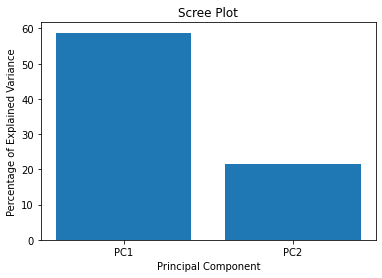

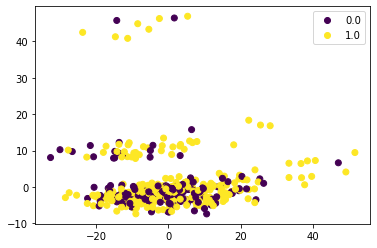

In [764]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [765]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y,test_size=0.2, random_state=40)

grid_pca = optimise(clf, params, X_pca, y, 0)
print(grid_pca.best_score_)

grid_pca.fit(X_pca_train, y_train)
y_pred = grid_pca.predict(X_pca_train)
print(f1_score(y_pred, y_train, average = 'macro'))
y_pred_test = grid_pca.predict(X_pca_test)
print(f1_score(y_pred_test, y_test, average = 'macro'))

0.5688794814461586
0.5838258018094531
0.569377990430622


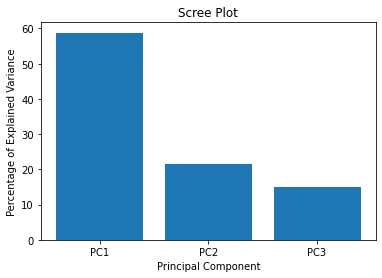

In [766]:
pca_3 = PCA(3)
X_pca_3 = pca_3.fit_transform(X)

per_var = np.round(pca_3.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

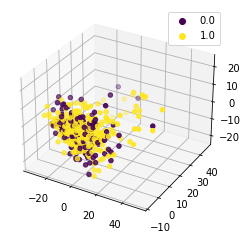

In [767]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [768]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

X_pca_3_train, X_pca_3_test, y_train, y_test = train_test_split(X_pca_3, y,test_size=0.2, random_state=40)

grid_pca_3 = optimise(clf, params, X_pca_3, y, 0)

print(grid_pca_3.best_score_)

grid_pca_3.fit(X_pca_3_train, y_train)

y_pred = grid_pca_3.predict(X_pca_3_train)
print(f1_score(y_pred, y_train, average = 'macro'))
y_pred_test = grid_pca_3.predict(X_pca_3_test)
print(f1_score(y_pred_test, y_test, average = 'macro'))

0.5432232471308874
0.5913815913815914
0.5924495924495924


## Model on scaled PCA data

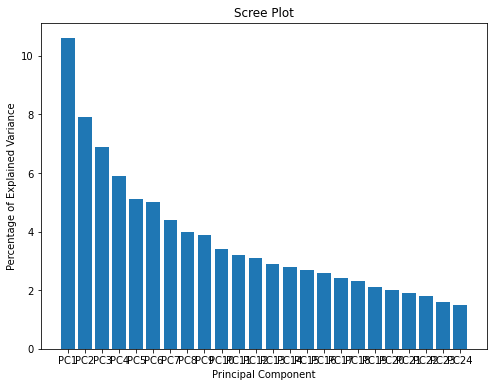

In [769]:
pca_scaled = PCA(24)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca_scaled)])
plt.figure(figsize=(8,6))
X_pca_scaled = pipe.fit_transform(X)

per_var = np.round(pca_scaled.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

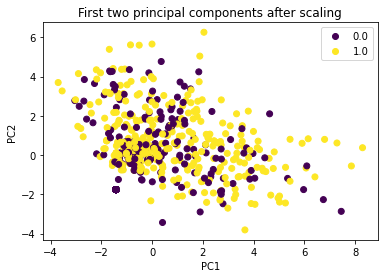

In [770]:
pca_df = pd.DataFrame(X_pca_scaled, index = X.index, columns = labels)
plot = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=y)
legend = list(y.unique())
plt.legend(handles=plot.legend_elements()[0], labels=legend)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components after scaling")
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()

In [771]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

params['solver'].append('sag')
params['solver'].append('saga')

grid_pca_scaled = optimise(clf, params, X_pca_scaled, y, 0)

X_pca_scaled_train, X_pca_scaled_test, y_train, y_test = train_test_split(X_pca_scaled, y,test_size=0.2, random_state=40)

print(grid_pca_scaled.best_score_)

grid_pca_scaled.fit(X_pca_scaled_train, y_train)
y_pred = grid_pca_scaled.predict(X_pca_scaled_train)
print(f1_score(y_pred, y_train, average = 'macro'))
y_pred_test = grid_pca_scaled.predict(X_pca_scaled_test)
print(f1_score(y_pred_test, y_test, average = 'macro'))

0.6987160645200886
0.716814010507881
0.6729699666295885


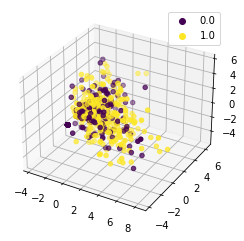

In [772]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [773]:
from matplotlib.colors import ListedColormap
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = {0.0:'red', 1.0:'green'}  
    print(Z.shape)
    print(Z.ravel().shape)
    print(X[:, 0].shape)
    print(X[:, 1].shape)
    
    colored_labels = np.array([colors[xi] for xi in y]) #Z.ravel()
    plt.contourf(xx, yy, Z, cmap='viridis')


    cb = plt.colorbar()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=colored_labels, cmap='viridis', s=10)

    plt.show()

(563, 864)
(486432,)
(748,)
(748,)


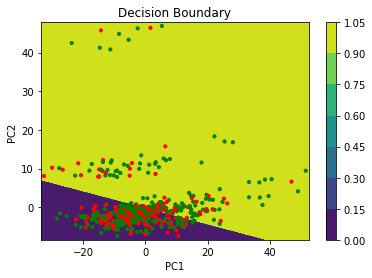

In [774]:
plot_decision_boundaries(X_pca, y, grid_pca.best_estimator_, 'Decision Boundary')

In [775]:
grid_normal.best_estimator_

LogisticRegression(C=0.06210169418915616, max_iter=10000)

In [776]:
grid_pca.best_estimator_

LogisticRegression(C=0.00038566204211634724, max_iter=1000, solver='liblinear')

In [777]:
grid_pca_3.best_estimator_

LogisticRegression(C=0.00038566204211634724, max_iter=1000, solver='liblinear')

In [778]:
grid_pca_scaled.best_estimator_

LogisticRegression(C=0.00038566204211634724, max_iter=1000, solver='sag')

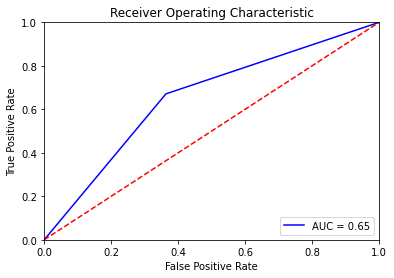

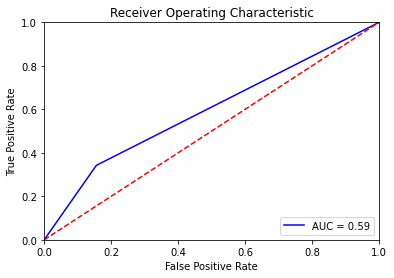

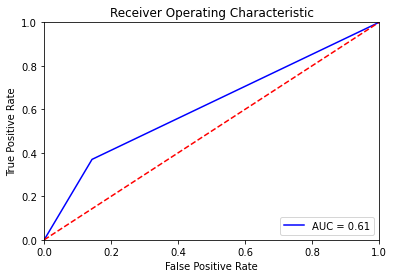

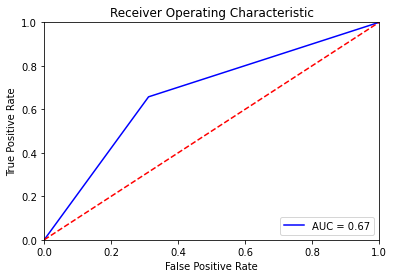

In [779]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


clfs = [grid_normal.best_estimator_, grid_pca.best_estimator_, 
        grid_pca_3.best_estimator_, grid_pca_scaled.best_estimator_]

X_tests = [X_test, X_pca_test, X_pca_3_test, X_pca_scaled_test]
X_trains = [X_train, X_pca_train, X_pca_3_train, X_pca_scaled_train]

for i in range(len(clfs)):
    preds = clfs[i].predict(X_tests[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [780]:
from sklearn.model_selection import learning_curve

#plot learning curve function from the labs
def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training Accuracy')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation Accuracy')

    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

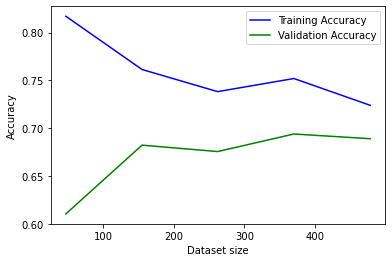

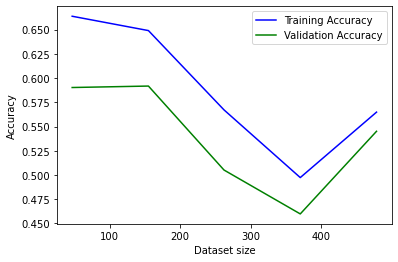

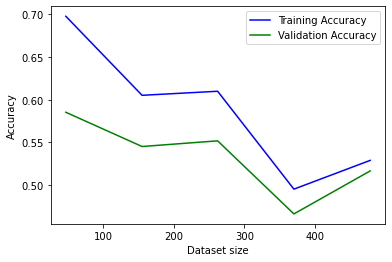

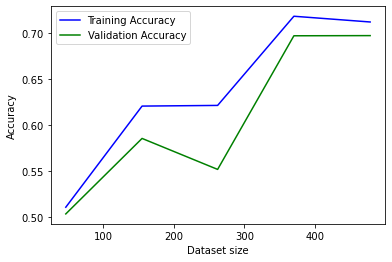

In [781]:
for i in range(len(clfs)):
    plot_learning_curve(5, clfs[i], X_trains[i], y_train, '')

In [782]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(est, X, y, p_name, p_range, title):
    train_scores, test_scores = validation_curve(estimator=est,
                                             X=X, y=y,
                                             cv=5,
    param_name=p_name, param_range=p_range)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(p_range, train_mean,
             color='blue', label='Training Accuracy')
    plt.plot(p_range, test_mean,
             color='green', label='Validation Accuracy')
    plt.xlabel(p_name)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid()
    plt.show()

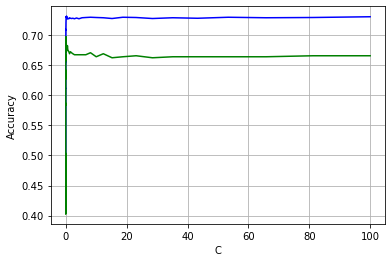

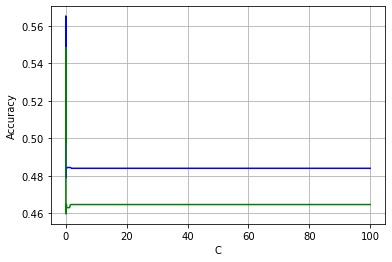

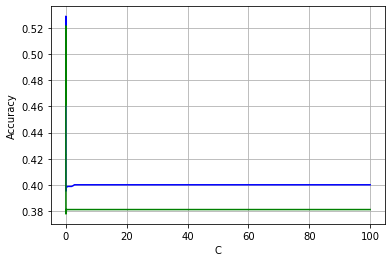

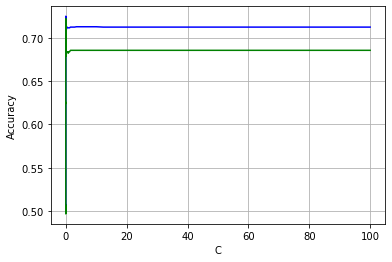

In [783]:
for i in range(len(clfs)):
    plot_validation_curve(clfs[i], X_trains[i], y_train, 'C', np.logspace(-7, 2, 100), '')

In [850]:
fullSample = full.sample(8000)
fullSample = fullSample.sort_index()
fullSample = fullSample.reset_index(drop = True)
X_full = fullSample.drop(dep, axis = 1).drop('dep', axis = 1)


pca_full = PCA(2)
X_full_pca = pca_full.fit_transform(X_full)

pca_full_3 = PCA(3)
X_full_pca_3 = pca_full_3.fit_transform(X_full)

pca_full_scaled = PCA(0.9)
pipe_full = Pipeline([('scaler', StandardScaler()), ('pca', pca_full_scaled)])
X_full_pca_scaled = pipe.fit_transform(X_full)

X_fulls = [X_full, X_full_pca, X_full_pca_3, X_full_pca_scaled]
y_full = fullSample['dep']

for i in range(len(clfs)):
    y_full_pred = clfs[i].predict(X_fulls[i])
    print(f1_score(y_full_pred, y_full, average='macro'))
    

0.44911785676360383
0.5050893366363518
0.2793515228427285
0.4539160696766073
